In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the model and encoders

In [23]:
# Load the dataset (replace with your actual file path)
# For example: df = pd.read_csv('/content/drive/MyDrive/haircut_recommendations_dataset1.csv')

from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/BeautiCareAi/haircut_recommendation/haircut_recommendations.csv')

# Show basic information about the dataset
print("Dataset loaded successfully. Shape of the dataset:", df.shape)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully. Shape of the dataset: (108329, 8)
   Gender Hair Type Face Shape Look Type Occasion  Haircut ID Haircut Name  \
0  Female  Straight      Round   Natural   Casual           7  Messy Waves   
1  Female  Straight      Round   Natural   Casual           7  Messy Waves   
2  Female  Straight      Round   Natural   Casual           7  Messy Waves   
3  Female  Straight      Round   Natural   Casual           7  Messy Waves   
4  Female  Straight      Round   Natural   Casual           7  Messy Waves   

                              Description  
0  Wavy hair with a messy and casual vibe  
1  Wavy hair with a messy and casual vibe  
2  Wavy hair with a messy and casual vibe  
3  Wavy hair with a messy and casual vibe  
4  Wavy hair with a messy and casual vibe  


In [24]:
from sklearn.preprocessing import LabelEncoder

# Drop the 'Description' column and define features (X) and target (y)
df = df.drop(columns=["Description","Haircut Name"])
X = df.drop(columns=["Haircut ID"])  # Features
y = df["Haircut ID"]  # Target variable

# Adjust the target labels to start from 0
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Impute missing values for categorical variables
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [25]:

label_encoders = {}
for column in X_imputed.columns:
    if X_imputed[column].dtype == 'object':  # Apply encoding only on object columns
        le = LabelEncoder()
        X_imputed[column] = le.fit_transform(X_imputed[column])
        label_encoders[column] = le
        print(f"Encoded column: {column} with classes: {le.classes_}")


Encoded column: Gender with classes: ['Female' 'Male']
Encoded column: Hair Type with classes: ['Curly' 'Straight']
Encoded column: Face Shape with classes: ['Oval' 'Round' 'Square']
Encoded column: Look Type with classes: ['Natural' 'Professional' 'Trendy']
Encoded column: Occasion with classes: ['Casual' 'Formal' 'Party' 'Sport']


In [26]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
best_accuracy = 0
best_params = {}

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Loop through the parameter grid manually
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:
                    print(f"Training with n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}")

                    # Initialize model with current parameters
                    model = xgb.XGBClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=42
                    )

                    # Fit the model
                    model.fit(X_train, y_train)

                    # Predict the results
                    y_pred = model.predict(X_test)

                    # Calculate accuracy
                    accuracy = accuracy_score(y_test, y_pred)
                    print(f"Accuracy: {accuracy:.4f}")

                    # Update the best parameters if current model is better
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree
                        }

# Output the best parameters
print("Best Parameters Found:")
print(best_params)


Training with n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7
Accuracy: 0.3794
Training with n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=1
Accuracy: 0.3471
Training with n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1, colsample_bytree=0.7
Accuracy: 0.3779
Training with n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1, colsample_bytree=1
Accuracy: 0.3473
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.7, colsample_bytree=0.7
Accuracy: 0.4058
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.7, colsample_bytree=1
Accuracy: 0.4081
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1, colsample_bytree=0.7
Accuracy: 0.4046
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1, colsample_bytree=1
Accuracy: 0.4092
Training with n_estimators=100, max_depth=3, learning_rate=0.3, subsample=0.

In [28]:
print(df.columns)  # Check column names


Index(['Gender', 'Hair Type', 'Face Shape', 'Look Type', 'Occasion',
       'Haircut ID'],
      dtype='object')


In [29]:
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.3,
    'subsample': 0.7,
    'colsample_bytree': 1
}

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       1.00      1.00      1.00      1663
           2       1.00      1.00      1.00      1627
           3       1.00      1.00      1.00      1679
           4       1.00      1.00      1.00      1696
           5       1.00      1.00      1.00      1752
           6       1.00      1.00      1.00      1659
           7       1.00      1.00      1.00      1622
           8       1.00      1.00      1.00      1649
           9       1.00      1.00      1.00      1675
          10       1.00      1.00      1.00      1673
          11       1.00      1.00      1.00      1727
          12       1.00      1.00      1.00      1614

    accuracy                           1.00     21666
   macro avg       1.00      1.00      1.00     21666
weighted avg       1.00      1.00      1.00     21666



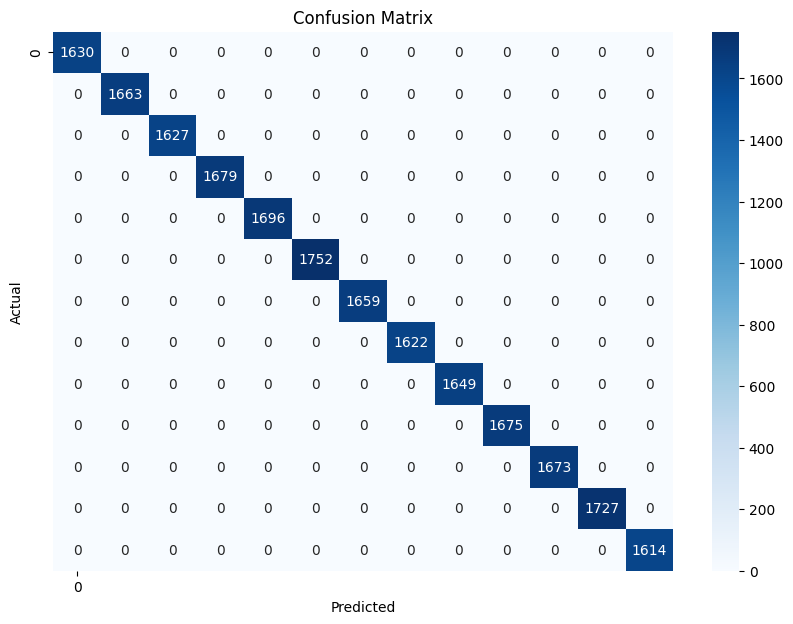

In [30]:
# Train the best model using the best parameters found
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict the results
y_pred = best_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_params['n_estimators'], yticklabels=best_params['n_estimators'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [32]:
# Save the model
model_path = "/content/drive/MyDrive/BeautiCareAi/haircut_recommendation/haircut_recommendation_model.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved successfully at {model_path}")

# Save the label encoders
label_encoders_path = "/content/drive/MyDrive/BeautiCareAi/haircut_recommendation/label_encoders.pkl"
joblib.dump(label_encoders, label_encoders_path)
print(f"Label encoders saved successfully at {label_encoders_path}")


Model saved successfully at /content/drive/MyDrive/BeautiCareAi/haircut_recommendation/haircut_recommendation_model.pkl
Label encoders saved successfully at /content/drive/MyDrive/BeautiCareAi/haircut_recommendation/label_encoders.pkl


In [33]:
# Load the model
loaded_model = joblib.load("/content/drive/MyDrive/BeautiCareAi/haircut_recommendation/haircut_recommendation_model.pkl")

# Load the label encoders
loaded_label_encoders = joblib.load("/content/drive/MyDrive/BeautiCareAi/haircut_recommendation/label_encoders.pkl")


print("Model, label encoders, and scaler loaded successfully!")


Model, label encoders, and scaler loaded successfully!


In [39]:
# Sample new data for prediction (replace with actual data)
new_data = pd.DataFrame({
    'Gender': ['Female', 'Male', 'Female'],
    'Hair Type': ['Straight', 'Straight', 'Straight'],
    'Face Shape': ['Round', 'Round', 'Round'],
    'Look Type': ['Natural', 'Natural', 'Natural'],
    'Occasion': ['Casual', 'Formal', 'Sport']
})

# Apply encoding for categorical features using the loaded label encoders
for column in new_data.columns:
    if column in loaded_label_encoders:
        le = loaded_label_encoders[column]

        # Handle unseen categories by replacing them with the most frequent class
        new_data[column] = new_data[column].apply(lambda x: x if x in le.classes_ else le.classes_[0])

        # Transform using saved encoder
        new_data[column] = le.transform(new_data[column])

# Ensure all columns are of type int, float, or bool
new_data = new_data.astype({col: 'int' for col in new_data.select_dtypes(include=['object']).columns})

# Predict haircut recommendations using the trained model
try:
    predictions = loaded_model.predict(new_data)
    print("Predictions made successfully!")
except ValueError as e:
    print(f"Error during prediction: {e}")

# Define haircut mapping
haircuts = {
    0: ("Middle Part", "A neat middle part style"),
    1: ("Modern Short", "A short, modern style for women"),
    2: ("Modern Side Part", "A trendy side-parted look"),
    3: ("Side Part", "Classic side part for a simple style"),
    4: ("Classic Short", "A timeless short haircut for women"),
    5: ("Formal Bang", "Bangs with a formal look"),
    6: ("Messy Waves", "Wavy hair with a messy and casual vibe"),
    7: ("Crew Cut", "A short and clean crew cut Male"),
    8: ("Curly Long", "Long curls for a bold look Male"),
    9: ("Curly Short", "Short curly style for men Male"),
    10: ("Layered Cut", "A layered haircut with volume Male"),
    11: ("Messy Waves", "Casual and messy wavy hair Male"),
    12: ("Shaggy Cut", "A shaggy, laid-back style Male"),
    13: ("Side Part", "A classic side part with a neat finish Male")
}

# Display predictions with descriptions
if 'predictions' in locals():
    for i, haircut_id in enumerate(predictions):
        name, description = haircuts.get(haircut_id, ("Unknown", "No description available"))
        print(f"Prediction {i+1}: {name} - {description}")

Predictions made successfully!
Prediction 1: Messy Waves - Wavy hair with a messy and casual vibe
Prediction 2: Curly Short - Short curly style for men Male
Prediction 3: Messy Waves - Wavy hair with a messy and casual vibe
